# 201904223 이동현 201904241 정효준

## 카카오  API로 주정차 단속 현황 전처리

In [1]:
import pandas as pd
import numpy as np

In [2]:
ipw0 = pd.read_csv('주정차 단속현황.csv',encoding='utf-8')
iwp0 = ipw0.dropna()
select = ["단속일시", "단속동", "단속장소", "위반내용", "견인지시"]
iwp0 = iwp0[select]
iwp0

,단속일시,단속동,단속장소,위반내용,견인지시
0,2022-01-01 2:29,중곡동,서울특별시 광진구 영화사로5길 19,교통소통장애,미견인
1,2022-01-01 6:41,중곡동,150-196,소화전,미견인
2,2022-01-01 7:02,구의동,서울 광진구 구의동 660-1 주차장앞,교통소통장애,미견인
3,2022-01-01 7:29,구의동,서울 광진구 구의동 6-4,횡단보도,견인처리
4,2022-01-01 10:55,구의동,리젠트오피스텔건너편,안전지대,미견인
...,...,...,...,...,...
39727,2023-02-28 20:43,군자동,군자빌딩,주정차금지(황색실선)구역,미견인
39728,2023-02-28 21:23,자양동,서울 광진구 자양동 659-32,보도,미견인
39729,2023-02-28 21:38,화양동,서울 광진구 능동로 154,보도,미견인
39730,2023-02-28 22:36,자양동,서울 광진구 자양동 12-10,교차로,미견인


따로 필요한걸 또 모음

In [3]:
use_cols=['단속동','단속장소']
iwp_select =iwp0[use_cols]
iwp_select

,단속동,단속장소
0,중곡동,서울특별시 광진구 영화사로5길 19
1,중곡동,150-196
2,구의동,서울 광진구 구의동 660-1 주차장앞
3,구의동,서울 광진구 구의동 6-4
4,구의동,리젠트오피스텔건너편
...,...,...
39727,군자동,군자빌딩
39728,자양동,서울 광진구 자양동 659-32
39729,화양동,서울 광진구 능동로 154
39730,자양동,서울 광진구 자양동 12-10


단속장소를 그룹화해서 중복되는 개수를 확인

In [4]:
iwp_select1=iwp_select.groupby(['단속장소'],as_index= False).agg('count')
iwp_select1

,단속장소,단속동
0,01월 01일,1
1,01월 02일,1
2,01월 03일,1
3,01월 06일,13
4,01월 19일,1
...,...,...
6004,프라임아파트 정문(213동),234
6005,하이프라자 광진군자점 인근,5
6006,한강북자전거길,4
6007,한국보건의료인 국가시험원 앞,81


단속동이 어느정도 큰 40이상만 추림

In [5]:
iwp_select2 = iwp_select1.loc[iwp_select1['단속동']  >= 40]
iwp_select2

,단속장소,단속동
140,150-196,49
206,187-13,43
359,238,52
472,265-10,47
552,320-4,74
...,...,...
6001,태양주유소 앞,304
6002,파리바게트 앞,430
6004,프라임아파트 정문(213동),234
6007,한국보건의료인 국가시험원 앞,81


iwp_select2를 따로 csv파일로 저장해서 약간의 전처리후에 다시 불러옴

In [6]:
select = pd.read_csv('iwp_select2.csv',encoding='cp949')
select

,단속장소,단속동
0,서울특별시 광진구 150-196,49
1,서울특별시 광진구 187-13,43
2,서울특별시 광진구 238,52
3,서울특별시 광진구 265-10,47
4,서울특별시 광진구 320-4,74
...,...,...
119,태양주유소 앞,304
120,파리바게트 앞,430
121,프라임아파트 정문(213동),234
122,한국보건의료인 국가시험원 앞,81


앞에 서울특별시 광진구가 안들어가면 주소로 좌표를 변환시킬 수 없을수있어서 변환해줌

In [7]:
select.loc[~select['단속장소'].str.startswith('서울특별시 광진구'), '단속장소'] = '서울특별시 광진구 ' + select['단속장소'].astype(str)
select

,단속장소,단속동
0,서울특별시 광진구 150-196,49
1,서울특별시 광진구 187-13,43
2,서울특별시 광진구 238,52
3,서울특별시 광진구 265-10,47
4,서울특별시 광진구 320-4,74
...,...,...
119,서울특별시 광진구 태양주유소 앞,304
120,서울특별시 광진구 파리바게트 앞,430
121,서울특별시 광진구 프라임아파트 정문(213동),234
122,서울특별시 광진구 한국보건의료인 국가시험원 앞,81


지오코드로 좌표를 얻었으나 정확도가 매우 떨어져 일단 select.csv파일로 저장한 다음에 결측치를 없애고 카카오 API를 이용해 정확한 좌표값을 얻기로 함

In [8]:
select1 = pd.read_csv('select.csv',encoding='cp949')
select1 = select1.dropna()
select1

,단속장소,단속동,위도,경도
1,서울특별시 광진구 187-13,43,37.538400,127.082800
2,서울특별시 광진구 238,52,37.538400,127.082800
3,서울특별시 광진구 265-10,47,37.538400,127.082800
4,서울특별시 광진구 320-4,74,37.538400,127.082800
5,서울특별시 광진구 328-2,61,37.538400,127.082800
...,...,...,...,...
100,서울특별시 광진구 천호대로124길 20,47,37.552269,127.089187
107,서울특별시 광진구 아차산로,267,37.538847,127.091973
108,서울특별시 광진구 아차산로78가길,44,37.549228,127.109177
109,서울특별시 광진구 아차산로78길,71,37.547899,127.108630


카카오 API를 이용해 정확한 좌표를 얻음

In [9]:
import requests

KAKAO_REST_API_KEY = '46e2fce99101f9ab4e04b79be6a2cde6' # 발급받은 API KEY

def convert_address_to_coordinates(address):

    url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
    header = {'Authorization': 'KakaoAK ' + KAKAO_REST_API_KEY}

    r = requests.get(url, headers=header)

    try:
        if r.status_code == 200:
            result = r.json()
            if result.get("documents"):
                lng = float(result["documents"][0]["address"]['x'])
                lat = float(result["documents"][0]["address"]['y'])
                return lat, lng
    except:
        pass

    return None

select['좌표'] = select['단속장소'].apply(convert_address_to_coordinates)


카카오 API로도 검색되지 않는 값들은 날림

In [10]:
filtered_select1 = select[select['좌표'].notnull()]
filtered_select1

,단속장소,단속동,좌표
52,서울특별시 광진구 광장동 320-4,111,"(37.5473373809602, 127.107685327963)"
53,서울특별시 광진구 광장동 325-2,49,"(37.5478599930278, 127.107550285568)"
54,서울특별시 광진구 광장동 381-16,89,"(37.5498543440012, 127.099652999512)"
55,서울특별시 광진구 광장동 381-17,57,"(37.5506410529896, 127.100235494072)"
56,서울특별시 광진구 광장동 381-48,85,"(37.5515026511822, 127.100266297776)"
57,서울특별시 광진구 광장동 381-49,64,"(37.552039882765, 127.099773943799)"
58,서울특별시 광진구 광장동 383-16,40,"(37.5498084687831, 127.100626155609)"
59,서울특별시 광진구 광장동 486-1,69,"(37.5390961031657, 127.100023385485)"
60,서울특별시 광진구 광장동 5-117,61,"(37.5519448203824, 127.101996776431)"
61,서울특별시 광진구 구의동 15-1,46,"(37.5535982795813, 127.097362094171)"


데이터를 예쁘게 다듬기

In [11]:
filtered_select1['좌표'] = filtered_select1['좌표'].apply(lambda coord: str(coord) if coord else None)
filtered_select1['위도'] = filtered_select1['좌표'].apply(lambda coord: float(coord.split(',')[0].strip('()')) if coord else None)
filtered_select1['경도'] = filtered_select1['좌표'].apply(lambda coord: float(coord.split(',')[1].strip('()')) if coord else None)
filtered_select1.drop('좌표', axis=1, inplace=True)
filtered_select1

C:\Users\HJ\AppData\Local\Temp\ipykernel_34860\4161508743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_select1['좌표'] = filtered_select1['좌표'].apply(lambda coord: str(coord) if coord else None)
C:\Users\HJ\AppData\Local\Temp\ipykernel_34860\4161508743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_select1['위도'] = filtered_select1['좌표'].apply(lambda coord: float(coord.split(',')[0].strip('()')) if coord else None)
C:\Users\HJ\AppData\Local\Temp\ipykernel_34860\4161508743.py:3: Se

,단속장소,단속동,위도,경도
52,서울특별시 광진구 광장동 320-4,111,37.547337,127.107685
53,서울특별시 광진구 광장동 325-2,49,37.547860,127.107550
54,서울특별시 광진구 광장동 381-16,89,37.549854,127.099653
55,서울특별시 광진구 광장동 381-17,57,37.550641,127.100235
56,서울특별시 광진구 광장동 381-48,85,37.551503,127.100266
57,서울특별시 광진구 광장동 381-49,64,37.552040,127.099774
58,서울특별시 광진구 광장동 383-16,40,37.549808,127.100626
59,서울특별시 광진구 광장동 486-1,69,37.539096,127.100023
60,서울특별시 광진구 광장동 5-117,61,37.551945,127.101997
61,서울특별시 광진구 구의동 15-1,46,37.553598,127.097362


In [12]:
import requests
url = 'https://raw.githubusercontent.com/vuski/admdongkor/master/ver20230401/HangJeongDong_ver20230401.geojson'
response = requests.get(url).json()

# 키 값 확인
response.keys()
# dict_keys(['type', 'name', 'crs', 'bbox', 'features'])

# 전국 데이터에서 서울시만 추출
seoul_geo = response.copy()
seoul_geo['features'] = []

# 서울시 행정동 경계만 추출
for i in response['features']:
    if i['properties']['sggnm'] == '광진구':
        seoul_geo['features'].append(i)

# 행정동 수 확인
len(seoul_geo['features'])
# 426

15

주차단속지역 시각화

In [13]:
import folium
from folium import Marker

m = folium.Map(location=[37.53913,127.08366], zoom_start=14)

folium.GeoJson(seoul_geo, name='지역구').add_to(m)

# 인덱스 재설정
filtered_select1 = filtered_select1.reset_index(drop=True)

for i in range(len(filtered_select1)):
      Marker(location = [filtered_select1.loc[i]['위도'], filtered_select1.loc[i]['경도']],
           icon=folium.Icon(color='blue'), radius = 100, color = 'skyblue', popup = filtered_select1.loc[i]['단속동'],
             fill_color= 'skyblue'
          ).add_to(m)


m


## 위치,경도 나와있는 데이터로 주정차 단속현황 구하기

In [14]:
ipw= pd.read_csv('주정차 단속현황.csv')
ipw

,단속일시,단속원금,단속동,단속장소,위반내용,견인지시
0,2022-01-01 2:29,40000,중곡동,서울특별시 광진구 영화사로5길 19,교통소통장애,미견인
1,2022-01-01 6:41,80000,중곡동,150-196,소화전,미견인
2,2022-01-01 7:02,40000,구의동,서울 광진구 구의동 660-1 주차장앞,교통소통장애,미견인
3,2022-01-01 7:29,40000,구의동,서울 광진구 구의동 6-4,횡단보도,견인처리
4,2022-01-01 10:55,40000,구의동,리젠트오피스텔건너편,안전지대,미견인
...,...,...,...,...,...,...
39727,2023-02-28 20:43,32000,군자동,군자빌딩,주정차금지(황색실선)구역,미견인
39728,2023-02-28 21:23,8000,자양동,서울 광진구 자양동 659-32,보도,미견인
39729,2023-02-28 21:38,32000,화양동,서울 광진구 능동로 154,보도,미견인
39730,2023-02-28 22:36,32000,자양동,서울 광진구 자양동 12-10,교차로,미견인


In [15]:
#필요한 칼럼만 추출
use_cols=['단속동','단속장소']
ipw=ipw[use_cols]
ipw.nunique()

단속동       22
단속장소    6009
dtype: int64

### 단속지점명 당 단속건수 구하기

In [16]:
#단속지점명 당 단속건수 구하기
ipw=ipw.groupby(['단속장소'],as_index= False).agg('count')
ipw.rename(columns={'단속장소':'단속지점명'},inplace = True)
ipw.rename(columns={'단속동':'단속건수'}, inplace = True)
ipw

,단속지점명,단속건수
0,01월 01일,1
1,01월 02일,1
2,01월 03일,1
3,01월 06일,13
4,01월 19일,1
...,...,...
6004,프라임아파트 정문(213동),234
6005,하이프라자 광진군자점 인근,5
6006,한강북자전거길,4
6007,한국보건의료인 국가시험원 앞,81


In [17]:
ipw.단속건수.sum() # 단속건수 39732개

39732

### 위도, 경도 값을 가지는 데이터 가져오기

In [18]:
ipw_a =pd.read_csv("서울시 광진구 불법주정차 위반 단속 CCTV 위치정보.csv")
ipw_a.head()

,고정형CCTV지번주소,위도,경도,자치구,단속지점명,현장구분
0,서울 광진구 광장동 334-2,37.547790,127.106990,광진구,SK강평주유소 앞,불법주정차구역
1,서울 광진구 광장동 445-3,37.543799,127.102410,광진구,광현교회 앞,불법주정차구역
2,서울 광진구 구의동 135,37.549593,127.081780,광진구,아차산역 5번출구 앞,불법주정차구역
3,서울 광진구 군자동 503,37.548609,127.071072,광진구,두산위브 앞,불법주정차구역
4,서울 광진구 구의동 66-62,37.545348,127.088420,광진구,국민은행 앞,불법주정차구역


### 단속건수와 위도,경도 값을 얻기 위해 두개의 데이터 테이블 벙합

In [19]:
#두개의 데이어프레임 병합 후 단속지점명 띄어씌기 삭제
ipw_merge=pd.merge(ipw,ipw_a)
ipw_merge['단속지점명']=ipw_merge['단속지점명'].str.replace(' ','')
ipw_merge.head()

,단속지점명,단속건수,고정형CCTV지번주소,위도,경도,자치구,현장구분
0,CU자양써밋플레이스점건너,342,서울 광진구 자양동 547-64,37.537536,127.068208,광진구,불법주정차구역
1,MB모터스옆,787,서울 광진구 중곡동 247-6,37.563661,127.078227,광진구,불법주정차구역
2,강변스파랜드앞,401,서울 광진구 구의동 593-15,37.535074,127.091264,광진구,불법주정차구역
3,강변역1번출구,744,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역
4,강변역4번출구,400,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역


In [20]:
ipw_merge['단속건수'].sum() #병합 후 단속건수 13966

13966

#### 행정동 정보가 나와있는 데이터

In [21]:
#행정동이 나와있는 데이터
ipw_b= pd.read_csv("광진구 불법주정차 편집본.csv")
ipw_b.head()

,고정형CCTV지번주소,위도,경도,자치구,단속지점명,현장구분
0,광진구 광장동 331-6,37.547710,127.106845,광진구,모두투어앞,불법주정차구역
1,광진구 광장동 445-3,37.543603,127.102431,광진구,광현교회앞,불법주정차구역
2,광진구 구의2동 96,37.551937,127.089448,광진구,아차산역 5번출구 앞,불법주정차구역
3,광진구 군자동 361-8,37.548913,127.070786,광진구,두산위브 앞,불법주정차구역
4,광진구 구의2동 66-62,37.545200,127.087981,광진구,국민은행앞,불법주정차구역


In [22]:
# merge를 사용하기 위하여 칼럼이름 같게 해주기
# replace를 통해 띄어쓰기 삭제해서 단속지점명을 최대한 같게 해주기
ipw_b=ipw_b[['고정형CCTV지번주소','단속지점명']]
ipw_b.rename(columns={'고정형CCTV지번주소':'행정동지번주소'}, inplace = True)
ipw_b['단속지점명']=ipw_b['단속지점명'].str.replace(' ','')
ipw_b.head()

,행정동지번주소,단속지점명
0,광진구 광장동 331-6,모두투어앞
1,광진구 광장동 445-3,광현교회앞
2,광진구 구의2동 96,아차산역5번출구앞
3,광진구 군자동 361-8,두산위브앞
4,광진구 구의2동 66-62,국민은행앞


### 위에서 만든 데이터 프레임과 행정동 데이터 프레임 합치기


In [23]:
# 위에서 합친 데이터프레임과 행정동이 나와있는 데이터프레임 합치기
ipw_hang=pd.merge(ipw_merge,ipw_b)
ipw_hang.head()

,단속지점명,단속건수,고정형CCTV지번주소,위도,경도,자치구,현장구분,행정동지번주소
0,CU자양써밋플레이스점건너,342,서울 광진구 자양동 547-64,37.537536,127.068208,광진구,불법주정차구역,자양4동 547-29
1,MB모터스옆,787,서울 광진구 중곡동 247-6,37.563661,127.078227,광진구,불법주정차구역,광진구 중곡1동 247-6
2,강변스파랜드앞,401,서울 광진구 구의동 593-15,37.535074,127.091264,광진구,불법주정차구역,광진구 구의3동 593-20
3,강변역1번출구,744,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역,광진구 구의3동 546-6
4,강변역4번출구,400,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역,광진구 구의3동 546-6


In [24]:
ipw_hang['단속건수'].sum() #행정동 데이터 병합한 후 단속건수 11796

11796

In [25]:
#도로명주소에서 행정동만 추출하기
def split_data(sp1):
    sp2 = sp1.split(" ")[1]
    if str.isdigit(sp2[0]):
        sp2 = sp1.split(" ")[0]
    return sp2

In [26]:
ipw_hang['행정동'] = ipw_hang['행정동지번주소'].apply(split_data)
ipw_hang.head()

,단속지점명,단속건수,고정형CCTV지번주소,위도,경도,자치구,현장구분,행정동지번주소,행정동
0,CU자양써밋플레이스점건너,342,서울 광진구 자양동 547-64,37.537536,127.068208,광진구,불법주정차구역,자양4동 547-29,자양4동
1,MB모터스옆,787,서울 광진구 중곡동 247-6,37.563661,127.078227,광진구,불법주정차구역,광진구 중곡1동 247-6,중곡1동
2,강변스파랜드앞,401,서울 광진구 구의동 593-15,37.535074,127.091264,광진구,불법주정차구역,광진구 구의3동 593-20,구의3동
3,강변역1번출구,744,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역,광진구 구의3동 546-6,구의3동
4,강변역4번출구,400,서울 광진구 구의동 546-6,37.535668,127.094522,광진구,불법주정차구역,광진구 구의3동 546-6,구의3동


In [27]:
#행정동별로 단속건수 구하기
ipw_hang1=ipw_hang.groupby(['행정동'],as_index = False).agg('sum').iloc[:,:2]
ipw_hang1

,행정동,단속건수
0,광장동,125
1,구의1동,991
2,구의2동,273
3,구의3동,4823
4,군자동,914
5,능동,224
6,자양1동,394
7,자양2동,817
8,자양4동,659
9,중곡1동,1352


In [28]:
#누락된 중곡4동 데이터 추가하기
joong_gok4=ipw[(ipw['단속지점명']=='우리은행 앞') | (ipw['단속지점명']=='공원약국 앞')]
joong_gok4=pd.DataFrame({'행정동':['중곡4동','자양3동'], '단속건수': ['624','0']})
joong_gok4

,행정동,단속건수
0,중곡4동,624
1,자양3동,0


In [29]:
ipw_data=pd.concat([ipw_hang1,joong_gok4])
ipw_data.index=range(len(ipw_data))
ipw_data


,행정동,단속건수
0,광장동,125
1,구의1동,991
2,구의2동,273
3,구의3동,4823
4,군자동,914
5,능동,224
6,자양1동,394
7,자양2동,817
8,자양4동,659
9,중곡1동,1352


## 단속건수 200개 단위로 나누기

In [30]:
ipw_hang0 = ipw_hang[(ipw_hang['단속건수'] > 0) & (ipw_hang['단속건수'] < 200)]
ipw_hang0.index = range(len(ipw_hang0))

ipw_hang200 = ipw_hang[(ipw_hang['단속건수'] > 200 ) & (ipw_hang['단속건수'] < 400)]
ipw_hang200.index = range(len(ipw_hang200))

ipw_hang400 = ipw_hang[ipw_hang['단속건수'] > 400]
ipw_hang400.index = range(len(ipw_hang400))

## 행정동 단위로 시각화

In [31]:
import requests
url = 'https://raw.githubusercontent.com/vuski/admdongkor/master/ver20230401/HangJeongDong_ver20230401.geojson'
response = requests.get(url).json()

# 키 값 확인
response.keys()
# dict_keys(['type', 'name', 'crs', 'bbox', 'features'])

# 전국 데이터에서 서울시만 추출
seoul_geo = response.copy()
seoul_geo['features'] = []

# 서울시 행정동 경계만 추출
for i in response['features']:
    if i['properties']['sggnm'] == '광진구':
        seoul_geo['features'].append(i)

# 행정동 수 확인
len(seoul_geo['features'])
# 426

15

In [32]:
import folium
from folium import Marker

m = folium.Map(
    location=[37.53913,127.08366],
    zoom_start=13, 
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

for i in range(len(ipw_hang0)):
      Marker(location = [ipw_hang0.loc[i]['위도'], ipw_hang0.loc[i]['경도']],
           tooltip=ipw_hang0.loc[i]['단속지점명'], icon=folium.Icon(color='blue')
          ).add_to(m) # 200건수 이하는 파랑색
for i in range(len(ipw_hang200)):
      Marker(location = [ipw_hang200.loc[i]['위도'], ipw_hang200.loc[i]['경도']],
           tooltip=ipw_hang200.loc[i]['단속지점명'], icon=folium.Icon(color='purple')
          ).add_to(m) # 200건수 400건수 이하는 보라색
for i in range(len(ipw_hang400)):
      Marker(location = [ipw_hang400.loc[i]['위도'], ipw_hang400.loc[i]['경도']],
           tooltip=ipw_hang400.loc[i]['단속지점명'], icon=folium.Icon(color='black')
          ).add_to(m) # 400건수 이상은 검정색
m


# 공영주차장 데이터

In [33]:
parking= pd.read_csv('광진구_공영주차장 정보.csv')
pl=parking.iloc[:,2:7]
pl.head()

,동명,시설명,위치,부지면적,주차면수 소계
0,중곡1동,중곡제일전통시장 공영,중곡1동 221-6,695,21
1,중곡2동,장신구,중곡2동 133-10,531,22
2,중곡2동,중곡동복개천,중곡2동 150-196,NaN,78
3,중곡3동,중곡3동마을공원,중곡3동 195-1,3038.3,162
4,중곡3동,중곡체육센터,중곡3동 168-8,"3,690.00",6


In [34]:
#겶측값 확인
pl.isnull().sum()

동명         0
시설명        0
위치         0
부지면적       4
주차면수 소계    0
dtype: int64

#### 결측값을 갖는 칼럼 드랍 후 행정동 별 주차면수 구하기

In [35]:
pl.drop("부지면적", axis= 1, inplace= True)
pl_space=(
    pl
    .groupby(['동명'])
    .agg('mean')
    .round(0)
    .astype('int64')
)
pl_space

,주차면수 소계
동명,
광장동,9
구의1동,103
구의2동,38
구의3동,91
군자동,44
능동,51
자양1동,24
자양2동,281
자양3동,94


<BarContainer object of 15 artists>

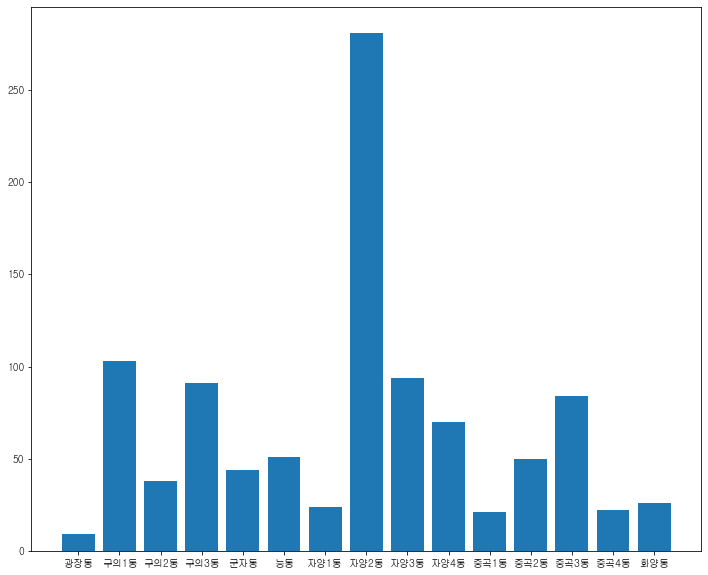

In [36]:
import matplotlib.pyplot as plt
 
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(pl_space.index, pl_space['주차면수 소계'])


# 가중치 값 선정을 위한 다중회귀 분석

전처리를 통해 만들어낸 데이터 세트를 불러옴

In [37]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
total = pd.read_csv('TotalDataSet2.csv')
total

,dong,domestic_living,foreign_living,car_registration,nomal_restaurant,m_traffic,w_traffic,pub,people,generation,street_parking,attached_parking,parking_space,ipw,large_store,public_parking
0,광장동,34823.37809,695.920133,11646,165,12182,12510,5,34061,11824,34,325,9,4671,1,3
1,구의1동,25200.11901,1087.781196,7005,411,19228,18744,12,23365,13139,14,1349,103,2060,0,2
2,구의2동,21965.38270,654.010771,7346,251,17194,15548,2,25875,11517,48,1270,38,3873,2,3
3,구의3동,30185.07775,622.406775,9127,216,31831,29823,4,28140,12128,31,677,91,4100,5,3
4,군자동,19470.59445,2085.954162,5223,350,6819,6139,3,19318,11385,15,987,44,2937,1,2
5,능동,16376.30002,801.634267,3060,135,32048,29653,0,11180,6463,42,816,51,2283,0,2
6,자양1동,23734.62140,1758.140987,7366,154,4423,4197,5,22134,12093,11,962,24,1572,0,1
7,자양2동,21138.19432,638.433025,7598,162,4711,4342,0,23745,10837,82,1165,281,1493,2,1
8,자양3동,24233.32138,813.777025,8970,293,4800,4291,3,27434,11004,48,671,94,2593,2,1
9,자양4동,27221.24540,6572.241967,5018,400,13596,9332,6,17958,10270,36,683,70,2201,3,2


In [38]:
from sklearn.preprocessing import StandardScaler

selected_columns = ["domestic_living","foreign_living","car_registration","nomal_restaurant","w_traffic", 
                    "pub","people","generation", "street_parking", "attached_parking", "parking_space", "large_store", "public_parking","ipw"]
total_selected = total[selected_columns]

scaler = StandardScaler()
total_scaled = scaler.fit_transform(total_selected)

total_scaled_df = pd.DataFrame(total_scaled, columns=selected_columns)
total_scaled_df

,domestic_living,foreign_living,car_registration,nomal_restaurant,w_traffic,pub,people,generation,street_parking,attached_parking,parking_space,large_store,public_parking,ipw
0,1.501853,-0.449244,2.289780,-0.639977,-0.069607,0.193892,2.036871,0.194992,-0.525974,-1.542029,-0.907866,-0.343203,0.360288,1.945199
1,0.163348,-0.251415,0.214355,0.664007,0.425107,2.229754,0.162344,0.714049,-1.284591,0.693724,0.558447,-1.078639,-0.240192,-0.564642
2,-0.286574,-0.470402,0.366848,-0.184113,0.171481,-0.678621,0.602234,0.073813,0.005057,0.521239,-0.455493,0.392232,0.360288,1.178116
3,0.856709,-0.486357,1.163300,-0.369639,1.304309,-0.096946,0.999187,0.314987,-0.639767,-0.773489,0.371258,2.598539,0.360288,1.396321
4,-0.633576,0.252508,-0.582544,0.340661,-0.575193,-0.387783,-0.546912,0.021710,-1.246660,-0.096650,-0.361899,-0.343203,-0.240192,0.278380
5,-1.063964,-0.395875,-1.549824,-0.799000,1.290818,-1.260296,-1.973137,-1.921104,-0.222528,-0.470003,-0.252705,-1.078639,-0.240192,-0.350282
6,-0.040490,0.087013,0.375792,-0.698285,-0.729306,0.193892,-0.053394,0.301172,-1.398383,-0.151233,-0.673880,-1.078639,-0.840673,-1.033735
7,-0.401628,-0.478266,0.479541,-0.655879,-0.717799,-1.260296,0.228941,-0.194597,1.294706,0.291987,3.335082,0.392232,-0.840673,-1.109675
8,0.028875,-0.389744,1.093090,0.038519,-0.721846,-0.387783,0.875457,-0.128679,0.005057,-0.786589,0.418055,0.392232,-0.840673,-0.052292
9,0.444467,2.517390,-0.674219,0.605699,-0.321805,0.484729,-0.785259,-0.418404,-0.450112,-0.760389,0.043677,1.127668,-0.240192,-0.429105


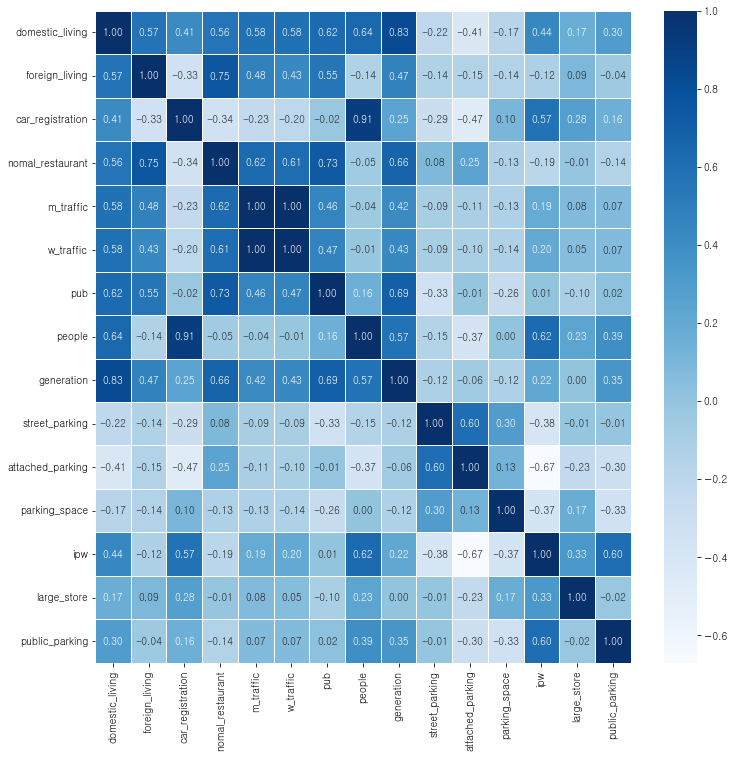

In [39]:
plt.figure(figsize=(12,12))
sns.heatmap(data=total.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()

iwp는 주차단속 건수로 종속변수로 하고 나머지 넣을 독립 변수를 찾아야하는데 히트맵을 통해 상관관계가 있어보이는 변수들을 우선적으로 넣어봄

In [40]:
x_data = total_scaled_df[["attached_parking", "people"]]
target = total_scaled_df[["ipw"]]


x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

C:\Algorithm\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ipw   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     9.452
Date:                Sat, 10 Jun 2023   Prob (F-statistic):            0.00343
Time:                        22:12:18   Log-Likelihood:                -14.189
No. Observations:                  15   AIC:                             34.38
Df Residuals:                      12   BIC:                             36.50
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.633e-17      0.180  -4.24e-16      1.000      -0.392       0.392
attached_parking    -0.5111      0.194     -2.637      0.022      -0.933      -0.089
people               0.4317      0.194      2.228      0.046       0.009       0.854
==============================================================================
Omnibus:                        0.354   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.443
Skew:                          -0.287   Prob(JB):                        0.801
Kurtosis:                       2.383   Cond. No.                         1.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

여러 변수들을 넣고 조율하는 시도 끝에 다중 공선성 문제가 없어 Prob (F-statistic) 와 
각 변수들의 Prob (F-statistic) P>|t|가 0.05보다 작고 R-squared가 어느정도 수준이 되는 
모델은 독립변수가 attached_parking와 people였고 coef에 따라 가중치는 각각 -0.51, 0.43이다

이 가중치를 각각의 변수 열의 값들과 곱한 후 모두 합쳐서 나온 값들로 최종적으로 입지 선정 행정동을 선정한다

In [41]:
total['remove_factor'] = total['attached_parking'] * -0.51
total['add_factor'] = total['attached_parking'] * 0.43

total['bout_factor'] = total['add_factor'] + total['remove_factor']
total.sort_values('bout_factor', ascending=False)

,dong,domestic_living,foreign_living,car_registration,nomal_restaurant,m_traffic,w_traffic,pub,people,generation,street_parking,attached_parking,parking_space,ipw,large_store,public_parking,remove_factor,add_factor,bout_factor
0,광장동,34823.37809,695.920133,11646,165,12182,12510,5,34061,11824,34,325,9,4671,1,3,-165.75,139.75,-26.00
13,중곡4동,25468.56078,445.267250,7382,63,2517,2279,3,27841,13124,50,553,22,4027,1,8,-282.03,237.79,-44.24
8,자양3동,24233.32138,813.777025,8970,293,4800,4291,3,27434,11004,48,671,94,2593,2,1,-342.21,288.53,-53.68
3,구의3동,30185.07775,622.406775,9127,216,31831,29823,4,28140,12128,31,677,91,4100,5,3,-345.27,291.11,-54.16
9,자양4동,27221.24540,6572.241967,5018,400,13596,9332,6,17958,10270,36,683,70,2201,3,2,-348.33,293.69,-54.64
5,능동,16376.30002,801.634267,3060,135,32048,29653,0,11180,6463,42,816,51,2283,0,2,-416.16,350.88,-65.28
6,자양1동,23734.62140,1758.140987,7366,154,4423,4197,5,22134,12093,11,962,24,1572,0,1,-490.62,413.66,-76.96
4,군자동,19470.59445,2085.954162,5223,350,6819,6139,3,19318,11385,15,987,44,2937,1,2,-503.37,424.41,-78.96
14,화양동,42015.48023,6406.366862,4186,890,50268,47441,12,23406,18258,64,1124,26,2561,1,3,-573.24,483.32,-89.92
7,자양2동,21138.19432,638.433025,7598,162,4711,4342,0,23745,10837,82,1165,281,1493,2,1,-594.15,500.95,-93.20


선정된 행정동은 광장동, 중곡4동, 자양3동, 구의3동, 자양4동이다

### 상위 5개 행정동의 공영주차장 데이터 가져오기

In [42]:
address_df=pl[(pl['동명'] == '중곡4동') | (pl['동명'] == '광장동') | (pl['동명'] == '자양3동') | (pl['동명'] == '구의3동') | (pl['동명'] == '자양4동')]
address_df=address_df[['동명','시설명','위치','주차면수 소계']]
address_df=address_df.sort_values(by = '동명')
address_df.index=range(len(address_df))
address_df

,동명,시설명,위치,주차면수 소계
0,광장동,큰나루,광장동 126,13
1,광장동,광장공동,광장동 394-43 외,8
2,광장동,세촌,광장동 275-5,7
3,구의3동,동서울길 공영,구의3동 609-1 일대,94
4,구의3동,올림픽대교(시영),구의3동 623-1,19
5,구의3동,구의3동 공영,구의3동 219-15,159
6,자양3동,송림식당길,자양3동 712 일대,94
7,자양4동,자양4동 공영,자양4동 5-5,86
8,자양4동,행복제2,자양4동 10-2,53
9,중곡4동,중곡4동 599-6 인근,면목4동 산75-2,9


## 공영주차장 좌표 데이터 

In [43]:
public_coord = pd.read_csv("공영주차장 좌표.csv")

In [44]:
#데이터 합치기
public_coord=pd.merge(public_coord,address_df)
public_coord

,시설명,위도,경도,동명,위치,주차면수 소계
0,큰나루,37.550327,127.110333,광장동,광장동 126,13
1,동서울길 공영,37.533309,127.091284,구의3동,구의3동 609-1 일대,94
2,올림픽대교(시영),37.539790,127.097598,구의3동,구의3동 623-1,19
3,송림식당길,37.534457,127.076127,자양3동,자양3동 712 일대,94
4,자양4동 공영,37.538623,127.068184,자양4동,자양4동 5-5,86
5,행복제2,37.539956,127.066323,자양4동,자양4동 10-2,53
6,신성시장길,37.557301,127.089911,중곡4동,중곡4동 453 일대,33
7,긴고랑길공영,37.560843,127.095125,중곡4동,중곡4동 72-1 외,53
8,용마산남,37.559038,127.092153,중곡4동,중곡4동 69-2,25
9,해오름,37.557038,127.091820,중곡4동,중곡4동 87-14,20



## 공영주차장과 주정차 단속구역 시각화`

In [45]:
import folium
from folium import Marker

m = folium.Map(location=[37.53913,127.08366], zoom_start=14)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)


for i in range(len(public_coord)):
      Marker(location = [public_coord.loc[i]['위도 '], public_coord.loc[i]['경도']],
           icon=folium.Icon(color='red'), tooltip =public_coord.loc[i]['주차면수 소계']
          ).add_to(m)


for i in range(len(public_coord)):
      folium.Circle(location = [public_coord.loc[i]['위도 '], public_coord.loc[i]['경도']],
           icon=folium.Icon(color='blue'), radius = 500, color = 'red', popup = 'public_p', fill_color= 'red'
          ).add_to(m)

for i in range(len(ipw_hang0)):
      Marker(location = [ipw_hang0.loc[i]['위도'], ipw_hang0.loc[i]['경도']],
           tooltip=ipw_hang0.loc[i]['단속지점명'], icon=folium.Icon(color='blue')
          ).add_to(m) # 200건수 이하는 파랑색
for i in range(len(ipw_hang200)):
      Marker(location = [ipw_hang200.loc[i]['위도'], ipw_hang200.loc[i]['경도']],
           tooltip=ipw_hang200.loc[i]['단속지점명'], icon=folium.Icon(color='purple')
          ).add_to(m) # 200건수 400건수 이하는 보라색
for i in range(len(ipw_hang400)):
      Marker(location = [ipw_hang400.loc[i]['위도'], ipw_hang400.loc[i]['경도']],
           tooltip=ipw_hang400.loc[i]['단속지점명'], icon=folium.Icon(color='black')
          ).add_to(m) # 400건수 이상은 검정색
        
filtered_select1 = filtered_select1.reset_index(drop=True)

for i in range(len(filtered_select1)):
      Marker(location = [filtered_select1.loc[i]['위도'], filtered_select1.loc[i]['경도']],
           icon=folium.Icon(color='green'), radius = 100, color = 'skyblue', popup = filtered_select1.loc[i]['단속동'], fill_color= 'skyblue'
          ).add_to(m) #카카오 API로 구한 단속지점



m

#### 중곡동 자양3동 구의3동 최종 선정